In [58]:
# CIFAR-10 consists of 60000 tiny 32x32 color (RGB) images
# airplane (0), automobile (1), bird (2), cat (3), deer (4), dog (5),
# frog (6), horse (7), ship (8), truck (9)

# The task is to classify birds from airplanes.

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import datasets

# download CIFAR10 Dataset
data_path = '../Deep-Learning-Pytorch/CIFAR-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


<PIL.Image.Image image mode=RGB size=32x32 at 0x1888448D748> 9 truck


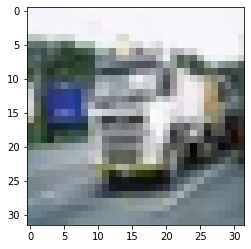

In [17]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

image,label = cifar10[1000]
image,label,class_names[label]
print(image,label,class_names[label])
plt.imshow(image)
plt.show()

In [19]:
from torchvision import transforms
tensor = transforms.ToTensor()
image_tensor = tensor(image)
image_tensor.shape

torch.Size([3, 32, 32])

In [32]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())
tensor_cifar10[10][1]

4

In [34]:
# Normalize the means and standard deviations
images = torch.stack([image_tensor for image_tensor, _ in tensor_cifar10],dim=3)
images.shape

torch.Size([3, 32, 32, 50000])

In [47]:
# Compute the mean and standard deviation per channel
means = images.view(3,-1).mean(dim=1)
stds = images.view(3,-1).std(dim=1)

# Normalize
transforms.Normalize(means,stds)

transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                      transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(means,stds)]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                      transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(means,stds)]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


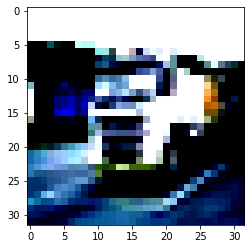

In [46]:
img_t, _ = transformed_cifar10[1000]
plt.imshow(img_t.permute(1, 2, 0)) # change the order of the axes from to CxHxW HxWxC
plt.show()

In [49]:
# Distinguish birds from airplanes
label_map = {0:0,2:1}  # dict
class_names = ['airplane','bird']

# extract birds and airplanes from datasets
cifar2 = [(img,label_map[label]) for img,label in transformed_cifar10 if label in [0,2]]
cifar2_val = [(img,label_map[label]) for img,label in transformed_cifar10_val if label in [0,2]]

In [72]:
# The following approach is to treat every input image as a 1D array which has 
# 3x32x32 = 3072 features

In [70]:
# build a neural network
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

# 2 output labels
n_out = 2    

# Minibatch and shuffle the data
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


# 3x32x32 = 3072 features per sample
model = nn.Sequential(OrderedDict([
    ('hidden_linear_1', nn.Linear(3072, 1024)),
    ('hidden_activation_1', nn.Tanh()),
    ('hidden_linear_2', nn.Linear(1024, 512)),
    ('hidden_activation_2', nn.Tanh()),
    ('hidden_linear_3', nn.Linear(512, 128)),
    ('hidden_activation_3', nn.Tanh()),
    ('output_linear', nn.Linear(128 , 2))
]))



# def Softmax(x):
#     return torch.exp(x)/torch.exp(x).sum()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

for epoch in range(n_epochs):
    for images,labels in train_loader:
        batch_size = images.shape[0]
        outputs = model(images.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.514506
Epoch: 1, Loss: 0.448507
Epoch: 2, Loss: 0.536932
Epoch: 3, Loss: 0.493312
Epoch: 4, Loss: 0.369245
Epoch: 5, Loss: 0.443058
Epoch: 6, Loss: 0.410149
Epoch: 7, Loss: 0.546905
Epoch: 8, Loss: 0.295824
Epoch: 9, Loss: 0.375231
Epoch: 10, Loss: 0.504208
Epoch: 11, Loss: 0.566898
Epoch: 12, Loss: 0.280595
Epoch: 13, Loss: 0.447684
Epoch: 14, Loss: 0.296341
Epoch: 15, Loss: 0.427864
Epoch: 16, Loss: 0.323210
Epoch: 17, Loss: 0.183696
Epoch: 18, Loss: 0.293747
Epoch: 19, Loss: 0.362383
Epoch: 20, Loss: 0.440555
Epoch: 21, Loss: 0.261526
Epoch: 22, Loss: 0.204288
Epoch: 23, Loss: 0.273779
Epoch: 24, Loss: 0.066540
Epoch: 25, Loss: 0.342016
Epoch: 26, Loss: 0.258981
Epoch: 27, Loss: 0.312982
Epoch: 28, Loss: 0.146749
Epoch: 29, Loss: 0.178875
Epoch: 30, Loss: 0.238655
Epoch: 31, Loss: 0.218035
Epoch: 32, Loss: 0.542647
Epoch: 33, Loss: 0.104610
Epoch: 34, Loss: 0.062471
Epoch: 35, Loss: 0.086642
Epoch: 36, Loss: 0.224507
Epoch: 37, Loss: 0.161553
Epoch: 38, Loss: 0.037

In [71]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.view(images.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.809000
